# Ensemble metody a regrese pro rozhodovací stromy

## Klasifikace a regrese 

- **Klasifikace**:  V předchozím cvičení jsme zkoušeli natrénovat model, který predikuje přežití pasažérů na Titanicu
    - Predikovali jsme veličinu která náleží do diskrétní množiny (zemřel/přežil) $y \in \{0, 1\}$ ✅. 
- **Regrese**:  V tomto cvičení se zaměříme na predikci spojité hodnoty kterou představuje cena domu
    - Problém, ve kterém predikujeme spojitou veličinu označujeme jako problém regrese 📈.

![https://miro.medium.com/max/1000/1*aLxkYI8694Ysy6k7WvHbGg.png](https://miro.medium.com/max/1000/1*aLxkYI8694Ysy6k7WvHbGg.png)

Rozhodovací stromy a potažmo ensemble metody lze využít jak pro klasifikaci, tak pro regresi! 🚀

## Dataset 🏘️
- V tomto notebooku si budeme hrát s populárním datasetem stahnutým z [Kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
- Jedná se o údaje o domech a jejich cenách. Cílem je předpovědět **cenu domu** (příznak **SalePrice**) na základě celkem 79 příznaků.

Popis jednotlivých dat i jednotlivých příznaků se nachází v souboru `data_description.txt`.

```python
# Show the data description
!cat data_description.txt
```

![https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)


In [1]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Answer to the Ultimate Question of Life, 
# the Universe, and Everything.
random_seed = 42

In [3]:
df = pd.read_csv('house-prices-train.csv')

In [4]:
df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

# Data preprocessing
První věc co po otevření datasetu uděláme? Zobrazíme si základní informace 😎.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df.SalePrice.value_counts()

140000    20
135000    17
145000    14
155000    14
190000    13
          ..
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, Length: 663, dtype: int64

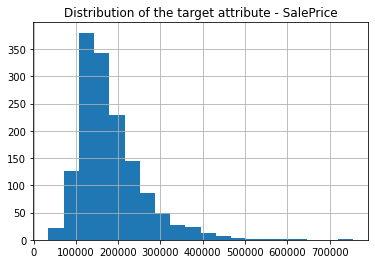

In [7]:
fig, ax = plt.subplots()
df.SalePrice.hist(bins=20)
ax.set_title("Distribution of the target attribute - SalePrice")
plt.show()

### První pokus o použití DecisionTreeRegressor

U Titanic datasetu jsme používali `DecisionTreeClassifier`, pro regresi využijeme jeho variantu `DecisionTreeRegressor`.

Tento kód selže hned na různých chybách pro různé typy sloupců:
```
[object] - Could not convert string to float
[float64] - Input contains NaN, infinity or a value too large for dtype('float32')
```

#### Jak tento problém opravit?
**Řešení 1**: Převedeme textové příznaky (`dtype = object`) na příznaky číselné.
- Zkusme nejprve nastavit jejich typ na *kategoriální* (`dtype = category`). Pandas si pak tyto příznaky interně ukládá jako číselné.
- Jako kategoriální lze chápat pouze příznaky *s ne moc různými hodnotami* (např. jméno není vhodné).
- V našem případě lze brát jako kategoriální všechny textové příznaky.

```python
# Zkonvertujeme sloupce typu object na typ category
for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')
```

Můžeme vyzkoušet zda se nám nyní podaří model natrénovat, s tímto řešením bohužel nepochodíme 😭. Proč? Implementace rozhodovacích stromů v `scikit-learn` nepodporuje `dtype = category`.

**Řešení 2**: Kategoriální proměnné nahradíme čísly. Jak?
- Pro řazené kategoriální příznaky (tzv. **ordinální**) je tento přístup v pořádku.
- Pro ty neřazené (**nominální**) je tento přístup poněkud nešťastný (čísla seřazená vždycky jsou).
- Nominální příznaky tak můžeme nahradit tzv. **dummy** přínzaky pomocí **one-hot encoding**.
    
Rozhodnutí, který příznak je nominální a který ordinální, lze stěží automatizovat a je nutné postupovat ručně. Dobrým kandidátem pro ordinální příznak je *KitchenQual*. 

In [8]:
display(df.KitchenQual.unique())

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

Dle popisu v souboru `data_description.txt`: Ex = Excellent, Gd = Good, TA = Typical/Average, Fa = Fair, Po = Poor. Takže bychom chtěli tyto textové hodnoty nahradit čísly tak, aby se zachovalo pořadí Po < Fa < TA < Gd < Ex.

In [9]:
print("Příznak KitchenQual před přemapováním:")
display(df.KitchenQual.sample(5, random_state=random_seed))

kitchen_quality_map = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4
}
df.KitchenQual = df.KitchenQual.replace(kitchen_quality_map)

print("Příznak KitchenQual po přemapování:")
display(df.KitchenQual.sample(5, random_state=random_seed))

Příznak KitchenQual před přemapováním:


892     TA
1105    Gd
413     TA
522     TA
1036    Ex
Name: KitchenQual, dtype: object

Příznak KitchenQual po přemapování:


892     2
1105    3
413     2
522     2
1036    4
Name: KitchenQual, dtype: int64

Vytvoříme funkci která která převede **ordinální** sloupce na **numerické** hodnoty a **nominální** na **one-hot encoding**

In [10]:
from sklearn.preprocessing import LabelEncoder

def encode_categories(df, mappers, dummies=False):
    label_encoder = LabelEncoder()
    for col in df.select_dtypes('object').columns:
        if col not in mappers and df[col].nunique() < 30:
            df[col] = df[col].fillna('NaN')
            df[col] = label_encoder.fit_transform(df[col])
            if dummies:
                df = pd.concat([
                    df.drop(columns=[col]), pd.get_dummies(df[col], prefix=('d_' + col))
                ], axis=1)
        elif col in mappers:
            df[col] = df[col].replace(mappers[col])
    return df        

In [11]:
data = pd.read_csv('house-prices-train.csv')

# Dictionary s mappingem ordinálních sloupců na číselné atributy
ordinal_cols_mappers = {
    'KitchenQual': {
        'Po' : 0, 
        'Fa' : 1, 
        'TA' : 2, 
        'Gd' : 3, 
        'Ex' : 4,
    }
}

data = encode_categories(data, ordinal_cols_mappers)
data = data.fillna('-1')

Zkusme to s DecisionTreeRegressor znovu.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   int64 
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   int64 
 6   Alley          1460 non-null   int64 
 7   LotShape       1460 non-null   int64 
 8   LandContour    1460 non-null   int64 
 9   Utilities      1460 non-null   int64 
 10  LotConfig      1460 non-null   int64 
 11  LandSlope      1460 non-null   int64 
 12  Neighborhood   1460 non-null   int64 
 13  Condition1     1460 non-null   int64 
 14  Condition2     1460 non-null   int64 
 15  BldgType       1460 non-null   int64 
 16  HouseStyle     1460 non-null   int64 
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

In [13]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(data.drop(columns=['SalePrice']), data.SalePrice)
print("Yahoooooo, the model had finished training, it 'works'!!! 🚀")

Yahoooooo, the model had finished training, it 'works'!!! 🚀


## Rozdělení dat

Adresář obsahuje CSV soubory `house-prices-train.csv` a `house-prices-test.csv`. `house-prices-test.csv` použijeme později. Pro naše účely použijeme `house-prices-train.csv` a rozdělíme ho na **trénovací**, **validační** a **testovací** množinu.

- **Trénovací dataset**: Trénovací dataset rozdělíme na trénovací a validační část.
    - **Trénovací množinu** uvidí model při trénování. 
    - **Validační množinu** používáme pro vyhodnocení performance modelu na datech, která přímo neviděl. 

Na základě validačních výsledků upravujeme hyperparametry modelu. Validační chyba je tedy zaujatá (až moc optimistická, vždyť jsme podle její hodnoty vybírali hyperparametry modelu!). Před odevzdáním finálního modelu do produkce obvykle chceme modelu dát co-nejvyšší množství informací. Na poslední natrénování před testovací evaluací se obecně trénovací a validační množina sloučí, aby měl model nejvyšší možné množství dat.

- **Testovací dataset**: slouží pouze k evaluaci finálního (tedy již vybraného a natrénovaného modelu). 

Typicky ho má u sebe klient aby si ověřil, jak dobře dodané řešení funguje na datech, která váš model (ani váš data-science tým 👨‍🔬) neměl možnost při trénování vidět.

![img/traintest.png](img/traintest.png)

In [14]:
from sklearn.model_selection import train_test_split

# Split the training dataset into 60% train
Xtrain, Xrest, ytrain, yrest = train_test_split(
    # Training columns except target, target values , magic constant, keep our output consitent
    data.drop(columns=['SalePrice']), data.SalePrice, test_size=0.4, random_state=random_seed
)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(
    Xrest, yrest, test_size=0.6, random_state=random_seed
)

# Rozhodovací stromy pro regresi
U Titanicu jsme si ukázali, že lze rozhodovací stromy použít pro klasifikaci. Nyní si ukážeme, že je lze využít i pro regresi!

### Metrika
V případě klasifikace jsme používali accuracy (kolik dat model predikoval správně). Nyní ovšem predikujeme spojitou proměnnou. Jak říct o výsledku, že je správně? Budeme měřit, jak daleko od kýženého výsledku se model strefil! Často používané metriky pro měření kvality regresního modelu jsou:

Název | Vzorec
----- | -------
MSE   | $$\frac{1}{n}\sum_{i=1}^{n}(Y_{i} - \hat{Y}_{i})^2$$
MAE   | $$\frac{1}{n}\sum_{i=1}^{n}|Y_{i} - \hat{Y}_{i}|$$
RMSLE | $$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(Y_{i} + 1) - log(\hat{Y}_{i} + 1))^2}$$

Výběr správné metriky je extrémně podstatný a často velice náročný úkol který musí data scientist umět vyřešit. Často bohužel naše metrika neodpovídá přesně tomu, čeho chceme dosáhnout. Jednotlivé metriky se liší v mnoha směrech:
- jak je můžeme interpretovat (co vyjadřují)
- jak snadno je (ne)lze zderivovat
- jak se chovají pro různá data (outliers)

Například pro zmíněné metriky
- MSE je citlivé na outliers (penalizuje je hodně)
- MAE se dá snadno interpretovat, méně citlivé na outliers
- RMSLE je sensitivní na malé deviace hodnot

In [15]:
def rmsle(y_true: pd.Series, y_hat: pd.Series) -> float:
    return math.sqrt(
        metrics.mean_squared_error(
            np.log1p(y_true), np.log1p(y_hat)
        )
    )

In [16]:
param_grid = {
    'max_depth': range(1,15)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    dt = DecisionTreeRegressor(**params).fit(Xtrain, ytrain)
    val_metric.append(rmsle(yval, dt.predict(Xval)))

In [17]:
# Vybereme nejlepší parametry
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSLE {min(val_metric):.4f}.")

# Natrénujeme na nich DecisionTreeRegressor
dt = DecisionTreeRegressor(**best_params).fit(Xtrain, ytrain)

We found the best params {'max_depth': 9} with validation RMSLE 0.1922.


In [18]:
train_rmsle_tree = rmsle(ytrain, dt.predict(Xtrain))
valid_rmsle_tree = rmsle(yval, dt.predict(Xval))
print(f"RMSLE (train): \t{train_rmsle_tree:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_tree:.4f}")

RMSLE (train): 	0.0730
RMSLE (valid): 	0.2059


```python
# Na toto se dívat nesmíme a nebudeme podvádět! 
# Na trénovacích datech ještě chceme trénovat další modely!
test_rmsle_tree = rmsle(ytest, dt.predict(Xtest))
print(f"RMSLE (test): \t{test_rmsle_tree:.4f}")
```

# Náhodný les `RandomForestRegressor`
Jak bylo řečeno v přednášce, random forest je postaven na bagging metodě:
- Trénuje se na bootstapu dat: vytvoříme **n** množin a do nich vybereme data výběrem s opakovnáním
- Každá množina se použije k natrénování jednoho stromu (vznikne jich tedy n)
- Výstupy ze jednotlivých stromečků jsou agregovány do finálního výstupu 
  
![img/bagging.png](img/bagging.png)

Použití lesa místo stromu je `sklearn` velice jednoduché:
- stačí nahradit `DecisionTreeRegressor` v kódu výše  třídou `RandomForestRegressor`.
- má skoro stejné parametry jako `DecisionTreeRegressor`. Například
    * `max_depth`, který určuje maximální hloubku jednoho stromu.
    * `max_features`, který určuje počet příznaků, ze kterých si hladový algoritmus vybírá ten, podle kterého bude v aktuálním kroku data "větvit".

Má ale také jeden nový (`n_estimators`), který je zásadní a určuje počet stromů v lese.

In [19]:
from sklearn.ensemble import RandomForestRegressor


param_grid = {
    'n_estimators': range(1, 100, 5),
    'max_depth': range(1, 5)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    dt = RandomForestRegressor(**params).fit(Xtrain, ytrain)
    val_metric.append(rmsle(yval, dt.predict(Xval)))

In [20]:
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSLE {min(val_metric):.4f}.")

forest_model = RandomForestRegressor(**best_params).fit(Xtrain, ytrain)

We found the best params {'n_estimators': 96, 'max_depth': 4} with validation RMSLE 0.1734.


In [21]:
train_rmsle_forest = rmsle(ytrain, forest_model.predict(Xtrain))
valid_rmsle_forest = rmsle(yval, forest_model.predict(Xval))
print(f"RMSLE (train): \t{train_rmsle_forest:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_forest:.4f}")

RMSLE (train): 	0.1618
RMSLE (valid): 	0.1766


# Úkol: Vyzkoušejte RandomForest pro klasifikaci na Titanic datasetu!

Titanic dataset již nyní důvěrně znáte, proto vám nebude činit potíže zkusit překonat performance rozhodovacího stromu z předchozího cvičení 😎.

In [22]:
titanic = pd.read_csv('titanic.csv')

# Tyto sloupce nebudeme nyní využívat (ale užitečné by být mohly!)
titanic = titanic.drop(columns=["Name", "Ticket", "Cabin"])

Data musíme předzpracovat (bohužel obsahují chybějící hodnoty a nečíselné atributy). Přidáme pár tipů:
- Preprocessing sloupců Sex a Embarked na one-hot encoding 
    - `pd.get_dummies(titanic, ...)`
- Chybějící hodnoty ve věku nahradíme např. mediánem 
    - to zdaleka není nejlepší způsob, ale jako baseline bude stačit
    
Nezapomeňte že accuracy chceme maximalizovat! (na rozdíl od RMSLE)

In [23]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [24]:
# Place your preprocessing code here :)
titanic = pd.get_dummies(titanic)  # Encode string columns using one-hot encoding

In [25]:
titanic.isnull().sum()

Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [26]:
# Train/Validation split
X, X_val, y, y_val = train_test_split(
    titanic.drop(columns=['Survived']), titanic.Survived, test_size=0.25, random_state=random_seed
)

In [27]:
# Use age median value to fill in missing values of age
age_median = X.Age.median()

X.loc[X.Age.isnull(), 'Age'] = age_median
X_val.loc[X_val.Age.isnull(), 'Age'] = age_median

Zkusíme nejdřív použít jednoduchý decision tree. Jakou validační accuracy se vám podařilo dosáhnout?

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Place your model training code here :)

param_grid = {
    'max_depth': range(1, 50)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    dt = DecisionTreeClassifier(**params).fit(X, y)
    val_metric.append(accuracy_score(y_val, dt.predict(X_val)))

In [29]:
best_res = np.max(val_metric)
best_params = param_comb[np.argmax(val_metric)]

print("Best validation accuracy is {}% with parameters {}".format(best_res, best_params))

Best validation accuracy is 0.8026905829596412% with parameters {'max_depth': 4}


Změňte hodnotu proměnné random_seed (klidně opakovaně) a znovu vyhodnoťte buňky obsahující dělení dat a trénink decision tree. Podařilo se vám překonat původní validační accuracy?

In [30]:
random_seed = 11

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Place your model training code here :)
param_grid = {
    'max_depth': range(1, 5),
    'n_estimators': range(1, 100, 10)
}

param_comb = ParameterGrid(param_grid)

val_metric_rf = []
for params in param_comb:
    dt = RandomForestClassifier(**params).fit(X, y)
    val_metric_rf.append(accuracy_score(y_val, dt.predict(X_val)))

In [32]:
best_res_rf = np.max(val_metric_rf)
best_params_rf = param_comb[np.argmax(val_metric_rf)]

print("Best validation accuracy is {}% with parameters {}".format(best_res_rf, best_params_rf))

Best validation accuracy is 0.820627802690583% with parameters {'n_estimators': 31, 'max_depth': 4}


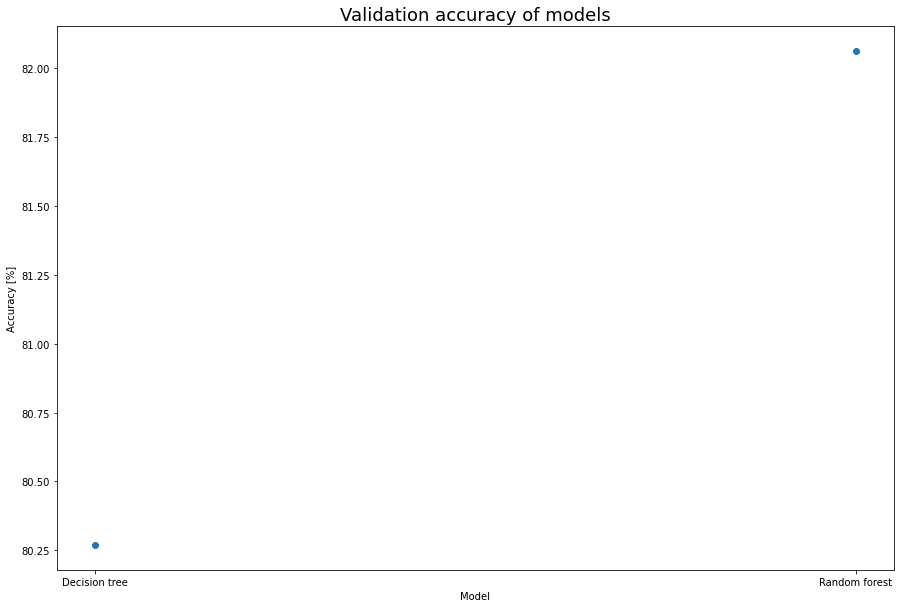

In [33]:
# Plot results in a simple scatter plot for comparison
plt.figure(figsize=(15,10))

plt.scatter(["Decision tree", "Random forest"], [best_res * 100, best_res_rf* 100])
plt.ylabel("Accuracy [%]")
plt.xlabel("Model")
plt.title("Validation accuracy of models", fontsize=18)
plt.show()

# Boosting - AdaBoost
Narozdíl od **random forest** používá **AdaBoost** metody boostingu:
- Na datech natrénujeme první strom (stromy se úmyslně volí s malou hloubkou)
- Data ohodnotíme podle "kvality" jejich predikce tímto stromem a přidáme jim váhu (ty co nebyly ohodnoceny dobře mají výšší váhu a opačně)
- Na základě těchto dat natrénujeme další strom, kterým se budeme snažit správně ohodnotit data s vyšší váhou
- Při predikci necháme všechny weak learners predikovat cílovou hodnotu kterou převážíme accuracy jednotlivých stromů a výsledek zagregujeme
    
![img/boosting.png](img/boosting.png)

Použití lesa místo stromu je `sklearn` velice jednoduché
- stačí nahradit `RandomForestRegressor` v kódu výše třídou `AdaBoostRegressor`

AdaBoostRegressor má dva hlavní volitelné parametry:
- `base_estimator`, který volí co bude použito za estimátor na data, v našem případě tedy **rozhodovací strom**
    - výchozí hodnota je **rozhodovací strom** hloubky 1 (lze využít i jiné modely)
- `n_estimators`, který říká kolik estimátorů (v našem případě **rozhodovacím stromů**) bude vytvořeno
    - výchozí hodnota je 50

In [34]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    'n_estimators': range(1,100,5),
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 1]
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    dt = AdaBoostRegressor(**params).fit(Xtrain, ytrain)
    val_metric.append(rmsle(yval, dt.predict(Xval)))

In [35]:
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSLE {min(val_metric):.4f}.")

ada_model = AdaBoostRegressor(**best_params).fit(Xtrain, ytrain)

We found the best params {'n_estimators': 86, 'learning_rate': 1} with validation RMSLE 0.1827.


In [36]:
train_rmsle_ada = rmsle(ytrain, ada_model.predict(Xtrain))
valid_rmsle_ada = rmsle(yval, ada_model.predict(Xval))
print(f"RMSLE (train): \t{train_rmsle_ada:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_ada:.4f}")

RMSLE (train): 	0.1799
RMSLE (valid): 	0.1909


# Porovnání výsledků
Porovnáme výsledky, a vybereme nejlepší model, který poté otestujeme na testovacích datech abychom zjistili jeho skutečnou performance

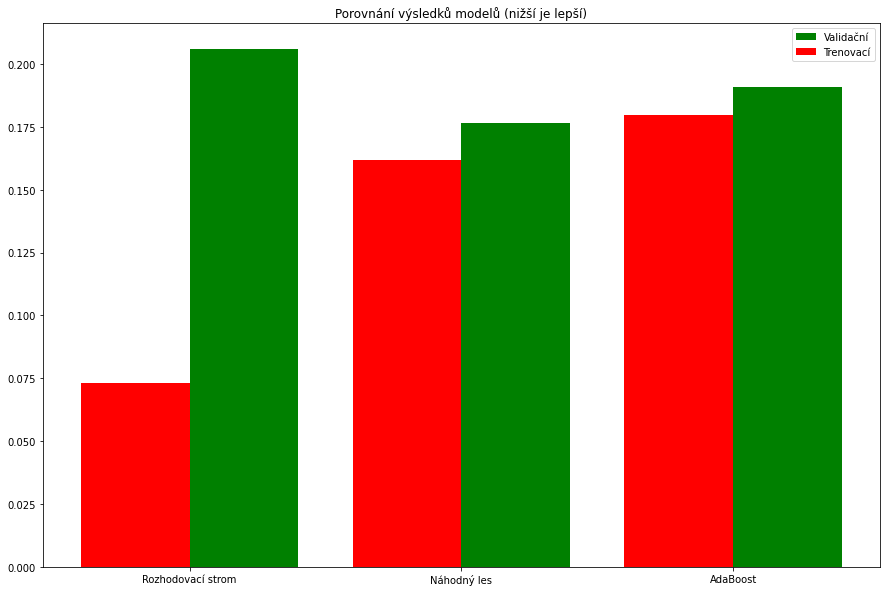

In [37]:
import matplotlib.pyplot as plt

results_val = [valid_rmsle_tree, valid_rmsle_forest, valid_rmsle_ada]
results_train = [train_rmsle_tree, train_rmsle_forest, train_rmsle_ada]

x_points_train = np.arange(len(results_val))
x_points_val = np.arange(0.4, len(results_val) + 0.4, 1)
x_points_labels = np.arange(0.2, len(results_val) + 0.2, 1)

plt.figure(figsize=(15,10))
plt.bar(x_points_val, results_val, label='Validační', color='g', width=0.4)
plt.bar(x_points_train, results_train, label='Trenovací', color='r', width=0.4)
plt.xticks(x_points_labels, ["Rozhodovací strom", "Náhodný les", "AdaBoost"])
plt.title("Porovnání výsledků modelů (nižší je lepší)")
plt.legend()
plt.show()

Jako nejlepší model zvolíme náhodný les a změříme jeho performance na testovacích datech. Nyní se již můžeme podívat na testovací chybu 📈.

In [38]:
test_rmsle_forest = rmsle(ytest, forest_model.predict(Xtest))
print(f"RMSLE (train): \t{train_rmsle_forest:.4f}")
print(f"RMSLE (valid): \t{valid_rmsle_forest:.4f}")
print(f"RMSLE (test): \t{test_rmsle_forest:.4f}")

RMSLE (train): 	0.1618
RMSLE (valid): 	0.1766
RMSLE (test): 	0.1830


# Úkol: Zkuste snížit RMSLE jak to jen jde a nahrát svoje řešení na Kaggle
Stránka pro odevzdání: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit

In [39]:
train = pd.read_csv('house-prices-train.csv')
test = pd.read_csv('house-prices-test.csv')

Kaggle při odevzdání počítá s CSV souborem, který má 2 sloupce `Id` a `SalePrice`. 

Příklad souboru který projde odevzdáním:

|   Id |   SalePrice |
|-----:|------------:|
| 1461 |      112317 |
| 1462 |      132388 |
| 1463 |      156409 |
| 1464 |      172197 |
| 1465 |      179526 |

Při ukládání můžete využít parametr `index=False` pro ignorování indexu.

```python
df.to_csv('kaggle_submission.csv', index=False)
```

In [40]:
# Your code goes here :)
